# Chapter 3: Static portfolio optimization


### 3.1 Explanation behind portfolio optimization method
> ###### 3.1.1 Systemic risk and specific risk
> ###### 3.1.2 Diversification

### 3.2 The traditional portfolio optimization methods
> ###### 3.2.1 Portfolio utility function
> ###### 3.2.2 Mean variance criterion
> ###### 3.3.3 Mean variance skewness kurtosis criterion

### 3.3 The modern portoflio optimization methods
> ###### 3.3.1 Sharpe criterion
> ###### 3.3.2 Sortino criterion


In [2]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf

In [20]:
# Importation of data
list_tickers = ['^DJI','CL=F','^GSPC']
database = yf.download(list_tickers)

# Take only the adjusted stock price
database = database["Adj Close"]

# Drop missing values
data = database.dropna().pct_change(1).dropna()

[*********************100%***********************]  3 of 3 completed


<br>
<br>
<br>



    
# 3.2.2 Mean variance optimization


In [21]:
def MV_criterion(weights, data):
    """
    -----------------------------------------------------------------------------
    | Output: optimization porfolio criterion                                   |
    -----------------------------------------------------------------------------
    | Inputs: -weight (type ndarray numpy): Wheight for portfolio               |
    |         -data (type ndarray numpy): Returns of stocks                     |
    -----------------------------------------------------------------------------
    """

    # Parameters
    Lambda = 3
    W = 1
    Wbar = 1 + 0.25 / 100

    # Compute portfolio returns
    portfolio_return = np.multiply(data, np.transpose(weights))
    portfolio_return = portfolio_return.sum(axis=1)

    # Compute mean and volatility of the portfolio
    mean = np.mean(portfolio_return, axis=0)
    std = np.std(portfolio_return, axis=0)

    # Compute the criterion
    criterion = Wbar ** (1 - Lambda) / (1 + Lambda) + Wbar ** (-Lambda) \
                * W * mean - Lambda / 2 * Wbar ** (-1 - Lambda) * W ** 2 * std ** 2
    criterion = -criterion
    
    return criterion

In [23]:
# Define train and test sets
split = int(0.7 * len(data))
train_set = data.iloc[:split, :]
test_set = data.iloc[split:, :]

# Find the number of asset
n = data.shape[1]

# Initialisation weight value
x0 = np.ones(n)

# Optimization constraints problem
cons = ({'type': 'eq', 'fun': lambda x: sum(abs(x)) - 1})

# Set the bounds
Bounds = [(0, 1) for i in range(0, n)]

# Optimization problem solving
res_MV = minimize(MV_criterion, x0, method="SLSQP",
                  args=(train_set), bounds=Bounds,
                  constraints=cons, options={'disp': True})

# Result for computations
X_MV = res_MV.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.24874453365966107
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2


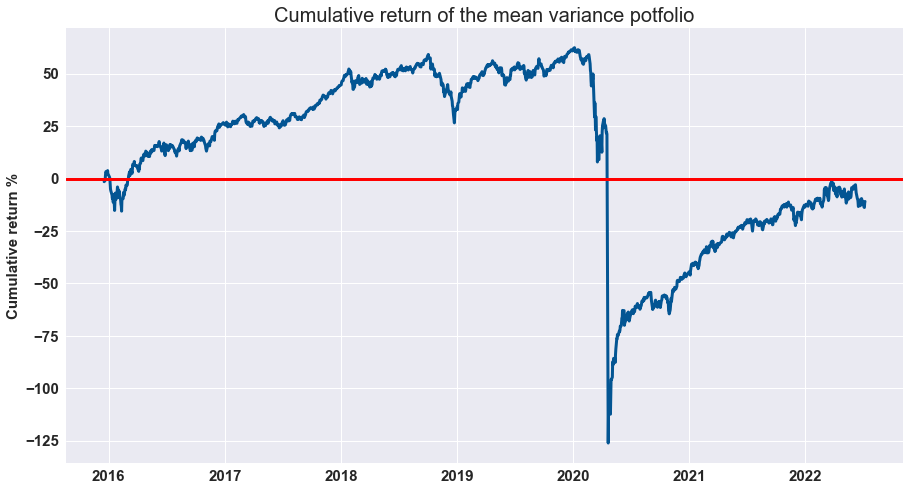

In [24]:
# Compute the cumulative return of the portfolio (CM)
portfolio_return_MV = np.multiply(test_set,np.transpose(X_MV))
portfolio_return_MV = portfolio_return_MV.sum(axis=1)

# Plot the CM
plt.figure(figsize=(15,8))
plt.plot(np.cumsum(portfolio_return_MV)*100, color="#035593", linewidth=3)
plt.ylabel("Cumulative return %", size=15, fontweight="bold")
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.title("Cumulative return of the mean variance potfolio", size=20)
plt.axhline(0, color="r",linewidth=3)
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Portfolio: ['CL=F', '^DJI', '^GSPC']
    -----------------------------------------------------------------------------
    Beta: 1.027 	 Alpha: -13.64 %	     Sharpe: -0.033 	 Sortino: -0.024
    -----------------------------------------------------------------------------
    VaR: 117.97 %	 cVaR: 135.42 % 	     VaR/cVaR: 1.148 	 drawdown: 103.7 %
    -----------------------------------------------------------------------------
    


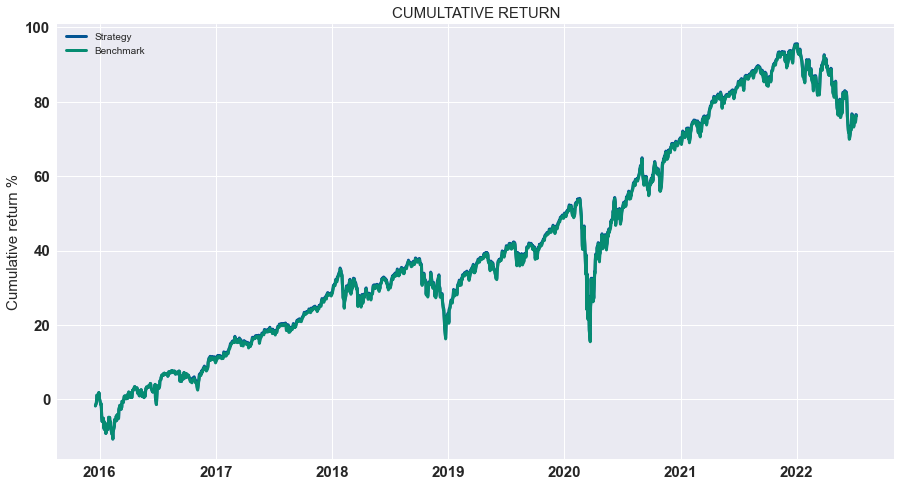

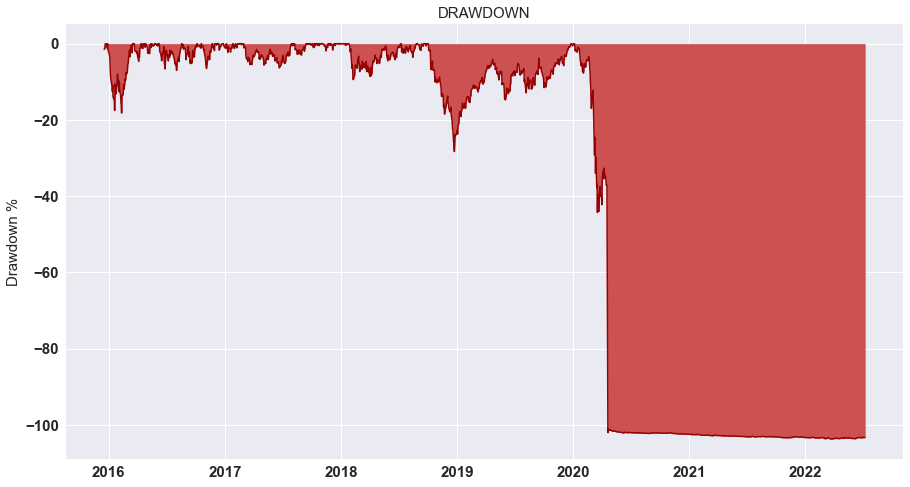

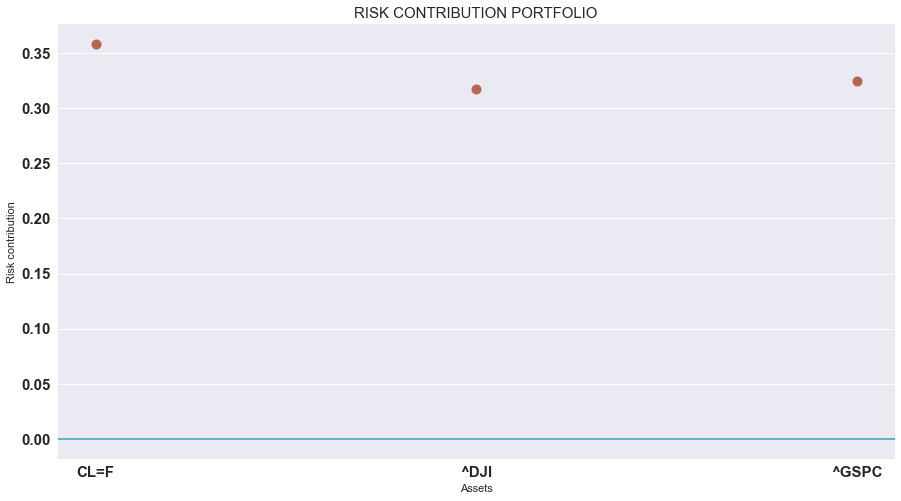

In [25]:
# Code from chapter 5
from Backtest import *
backtest_static_portfolio(X_MV, test_set, CR=True)

<br>
<br>
<br>



# 3.2.3 Mean variance skewness kurtosis

In [26]:
def SK_criterion(weights, data):
    """ 
    -----------------------------------------------------------------------------
    | Output: optimization porfolio criterion                                   |
    -----------------------------------------------------------------------------
    | Inputs: -weight (type ndarray numpy): Wheight for portfolio               |
    |         -data (type ndarray numpy): Returns of stocks                     |
    -----------------------------------------------------------------------------
    """
    from scipy.stats import skew, kurtosis
    # Parameters
    Lambda = 3
    W = 1
    Wbar = 1 + 0.25 / 100

    # Compute portfolio returns
    portfolio_return = np.multiply(data, np.transpose(weights))
    portfolio_return = portfolio_return.sum(axis=1)

    # Compute mean, volatility, skew, kurtosis of the portfolio
    mean = np.mean(portfolio_return, axis=0)
    std = np.std(portfolio_return, axis=0)
    skewness = skew(portfolio_return, 0)
    kurt = kurtosis(portfolio_return, 0)

    # Compute the criterion
    criterion = Wbar ** (1 - Lambda) / (1 + Lambda) + Wbar ** (-Lambda) \
    * W * mean - Lambda / 2 * Wbar ** (-1 - Lambda) * W ** 2 * std ** 2 \
    + Lambda * (Lambda + 1) / (6) * Wbar ** (-2 - Lambda) * W ** 3 * skewness \
    - Lambda * (Lambda + 1) * (Lambda + 2) / (24) * Wbar ** (-3 - Lambda) *\
     W ** 4 * kurt
    
    criterion = -criterion
    
    return criterion

In [27]:
# Find the number of asset
n = data.shape[1]

# Initialization weight value
x0 = np.ones(n)

# Optimization constraints problem
cons = ({'type': 'eq', 'fun': lambda x: sum(abs(x)) - 1})

# Set the bounds
Bounds = [(0, 1) for i in range(0, n)]

# Optimization problem solving
res_SK = minimize(SK_criterion, x0, method="SLSQP",
                  args=(train_set), bounds=Bounds,
                  constraints=cons, options={'disp': True})

# Result 
X_SK = res_SK.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 10.130240475932183
            Iterations: 8
            Function evaluations: 33
            Gradient evaluations: 8


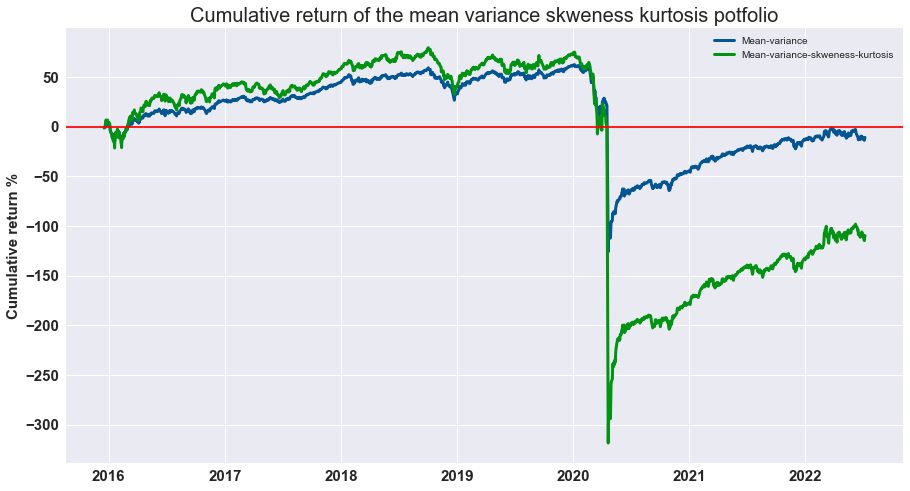

In [28]:
# Compute the cumulative return of the portfolio (CM)
portfolio_return_SK = np.multiply(test_set,np.transpose(X_SK))
portfolio_return_SK = portfolio_return_SK.sum(axis=1)

# Plot the CM
fig = plt.figure(figsize=(15,8))
plt.plot(np.cumsum(portfolio_return_MV)*100, color="#035593", linewidth=3)
plt.plot(np.cumsum(portfolio_return_SK)*100, color="#039313", linewidth=3)
plt.ylabel("Cumulative return %", size=15, fontweight="bold")
plt.axhline(0, color="r")
plt.legend(["Mean-variance", "Mean-variance-skweness-kurtosis"])
plt.title("Cumulative return of the mean variance skweness kurtosis potfolio", size=20)
plt.xticks(size=15, fontweight="bold")
plt.yticks(size=15, fontweight="bold")
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Portfolio: ['CL=F', '^DJI', '^GSPC']
    -----------------------------------------------------------------------------
    Beta: 1.077 	 Alpha: -29.36 %	     Sharpe: -0.165 	 Sortino: -0.118
    -----------------------------------------------------------------------------
    VaR: 254.94 %	 cVaR: 289.7 % 	     VaR/cVaR: 1.136 	 drawdown: 145.52 %
    -----------------------------------------------------------------------------
    


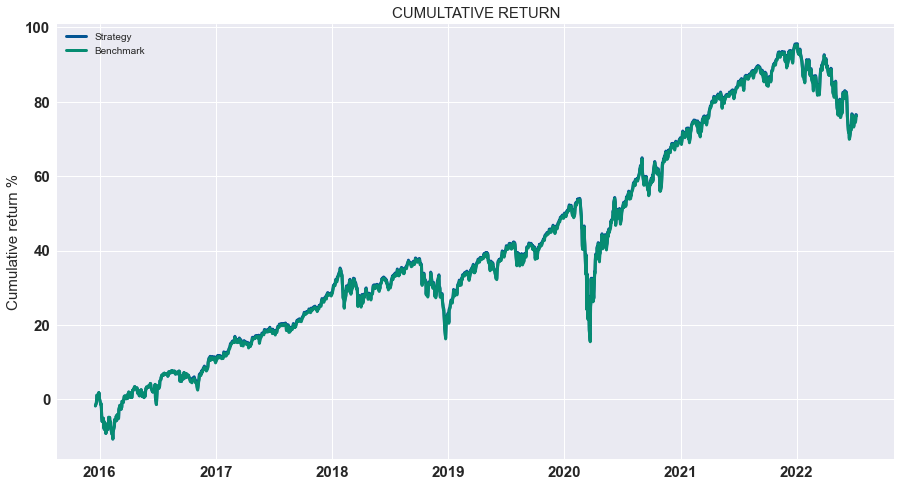

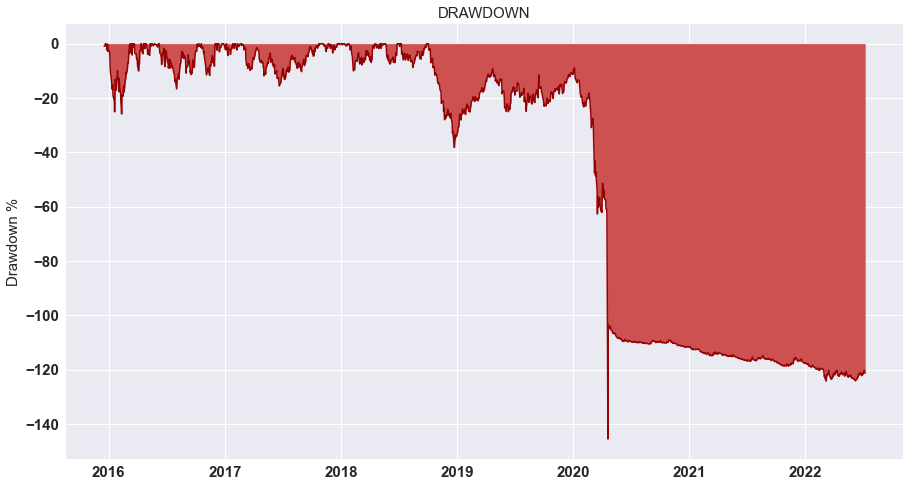

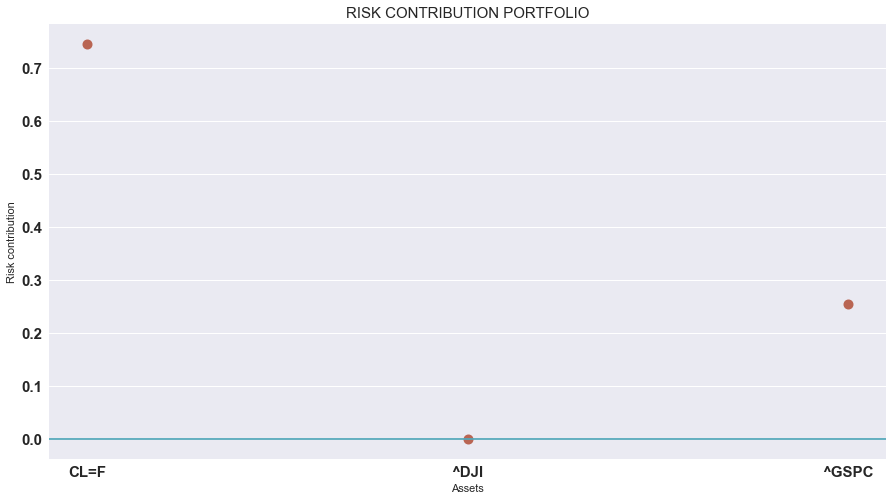

In [29]:
backtest_static_portfolio(X_SK, test_set, CR=True)

<br>
<br>
<br>



# 3.3.1 Sharpe ratio criterion

In [30]:
def SR_criterion(weight, data):
    """ 
    -----------------------------------------------------------------------------
    | Output: Opposite Sortino ratio to do a mimization                         |
    -----------------------------------------------------------------------------
    | Inputs: -Weight (type ndarray numpy): Wheight for portfolio               |
    |         -data (type dataframe pandas): Returns of stocks                  |
    -----------------------------------------------------------------------------
    """
    # Compute portfolio returns
    portfolio_return = np.multiply(data, np.transpose(weight))
    portfolio_return = portfolio_return.sum(axis=1)

    # Compute mean, volatility of the portfolio
    mean = np.mean(portfolio_return, axis=0)
    std = np.std(portfolio_return, axis=0)

    # Compute the opposite of the Sharpe ratio
    Sharpe = mean / std
    Sharpe = -Sharpe
    return Sharpe

In [31]:
# Find the number of asset
n=data.shape[1]

# Initialization weight value
x0 = np.ones(n)

# Optimization constraints problem
cons=({'type':'eq', 'fun': lambda x:sum(abs(x))-1})

# Set the bounds
Bounds= [(0 , 1) for i in range(0,n)]


# Optimization problem solving
res_SR = minimize(SR_criterion, x0, method="SLSQP",
                  args=(train_set),bounds=Bounds,
                  constraints=cons,options={'disp': True})

# Result for computations
X_SR = res_SR.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.018958670863901145
            Iterations: 12
            Function evaluations: 48
            Gradient evaluations: 12


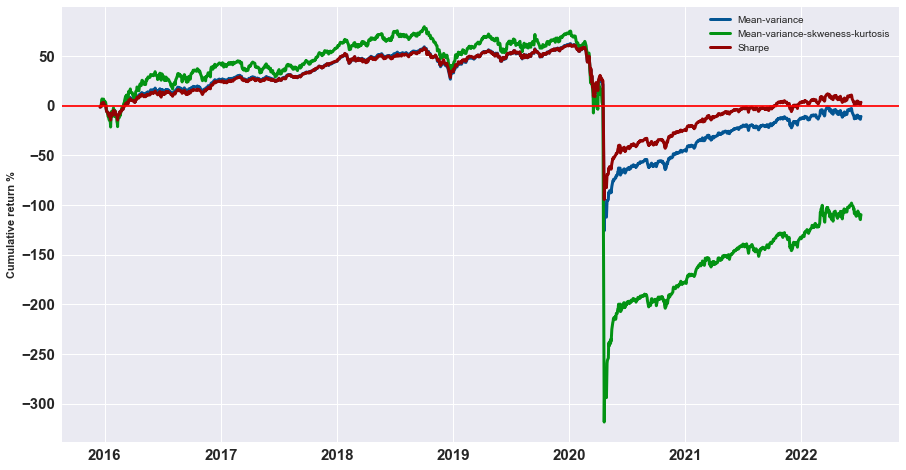

In [32]:
# Compute the cumulative return of the portfolio (CM)
portfolio_return_SR = np.multiply(test_set,np.transpose(X_SR))
portfolio_return_SR = portfolio_return_SR.sum(axis=1)

# Plot the CM
plt.figure(figsize=(15,8))
plt.plot(np.cumsum(portfolio_return_MV)*100, color="#035593", linewidth=3)
plt.plot(np.cumsum(portfolio_return_SK)*100, color="#039313", linewidth=3)
plt.plot(np.cumsum(portfolio_return_SR)*100, color="#930303", linewidth=3)
plt.ylabel("Cumulative return %",fontweight="bold")
plt.axhline(0, color="r")
plt.legend(["Mean-variance", "Mean-variance-skweness-kurtosis", "Sharpe"])
#plt.title("Cumulative return of the best Sharpe potfolio", size=20)
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Portfolio: ['CL=F', '^DJI', '^GSPC']
    -----------------------------------------------------------------------------
    Beta: 1.011 	 Alpha: -11.27 %	     Sharpe: 0.012 	 Sortino: 0.009
    -----------------------------------------------------------------------------
    VaR: 97.54 %	 cVaR: 112.63 % 	     VaR/cVaR: 1.155 	 drawdown: 93.11 %
    -----------------------------------------------------------------------------
    


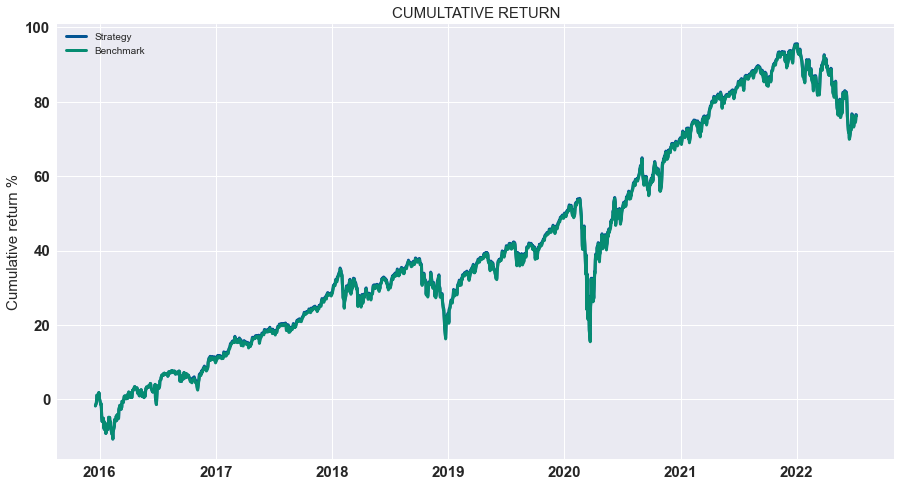

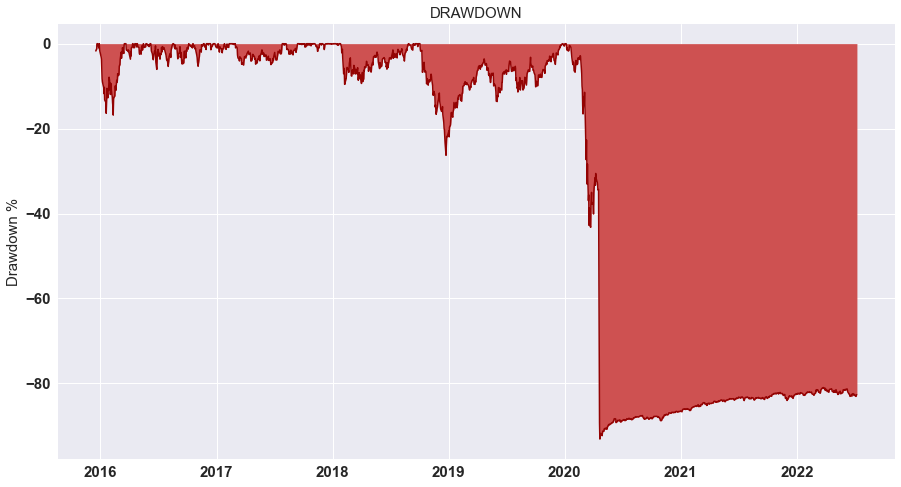

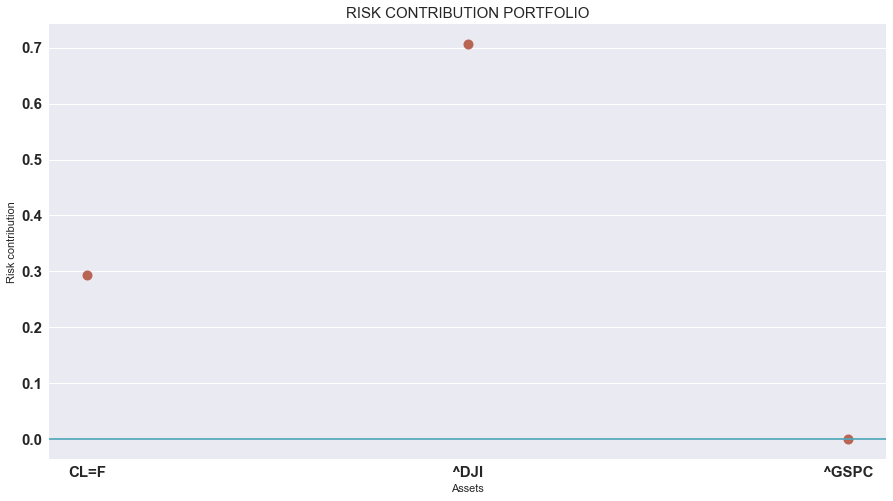

In [33]:
backtest_static_portfolio(X_SR, test_set, CR=True)

<br>
<br>
<br>



# 3.3.2 Sortino ratio criterion

In [34]:
def SOR_criterion(weight, data):
    """ 
    -----------------------------------------------------------------------------
    | Output: Opposite Sortino ratio to do a m imization                        |
    -----------------------------------------------------------------------------
    | Inputs: -Weight (type ndarray numpy): Wheight for portfolio               |
    |         -data (type dataframe pandas): Returns of stocks                  |
    -----------------------------------------------------------------------------
    """
    # Compute portfolio returns
    portfolio_return = np.multiply(data, np.transpose(weight))
    portfolio_return = portfolio_return.sum(axis=1)

    # Compute mean, volatility of the portfolio
    mean = np.mean(portfolio_return, axis=0)
    std = np.std(portfolio_return[portfolio_return < 0], axis=0)

    # Compute the opposite of the Sharpe ratio
    Sortino = mean / std
    Sortino = -Sortino
    
    return Sortino

In [35]:
# Find the number of asset
n=data.shape[1]

# Initialization weight value
x0 = np.zeros(n)+1/n

# Optimization constraints problem
cons=({'type':'eq', 'fun': lambda x:sum(abs(x))-1})

# Set the bounds
Bounds= [(0 , 1) for i in range(0,n)]


# Optimization problem solving
res_SOR = minimize(SOR_criterion, x0, method="SLSQP",
                  args=(train_set),bounds=Bounds,
                  constraints=cons,options={'disp': True})

# Result for computations
X_SOR = res_SOR.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.025165441078395023
            Iterations: 11
            Function evaluations: 44
            Gradient evaluations: 11


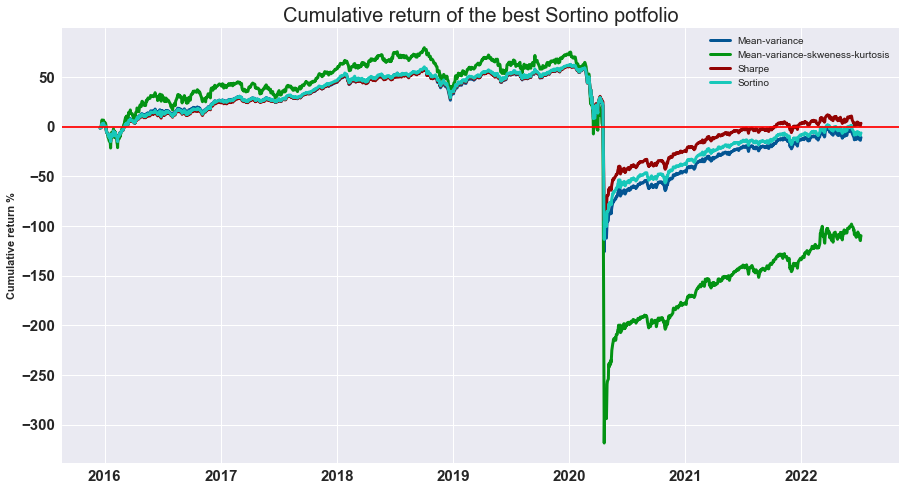

In [36]:
# Compute the cumulative return of the portfolio (CM)
portfolio_return_SOR = np.multiply(test_set,np.transpose(X_SOR))
portfolio_return_SOR = portfolio_return_SOR.sum(axis=1)




# Plot the CM
plt.figure(figsize=(15,8))
plt.plot(np.cumsum(portfolio_return_MV)*100, color="#035593", linewidth=3)
plt.plot(np.cumsum(portfolio_return_SK)*100, color="#039313", linewidth=3)
plt.plot(np.cumsum(portfolio_return_SR)*100, color="#930303", linewidth=3)
plt.plot(np.cumsum(portfolio_return_SOR)*100, color="#18C8BA", linewidth=3)
plt.ylabel("Cumulative return %",fontweight="bold")
plt.axhline(0, color="r")
plt.legend(["Mean-variance", "Mean-variance-skweness-kurtosis", "Sharpe", "Sortino"])
plt.title("Cumulative return of the best Sortino potfolio", size=20)
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Portfolio: ['CL=F', '^DJI', '^GSPC']
    -----------------------------------------------------------------------------
    Beta: 1.016 	 Alpha: -12.82 %	     Sharpe: -0.021 	 Sortino: -0.016
    -----------------------------------------------------------------------------
    VaR: 109.96 %	 cVaR: 125.89 % 	     VaR/cVaR: 1.145 	 drawdown: 98.3 %
    -----------------------------------------------------------------------------
    


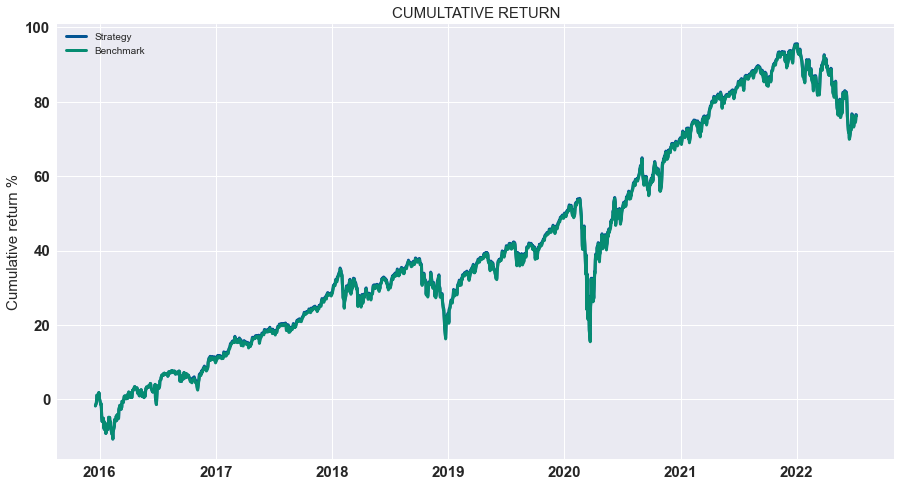

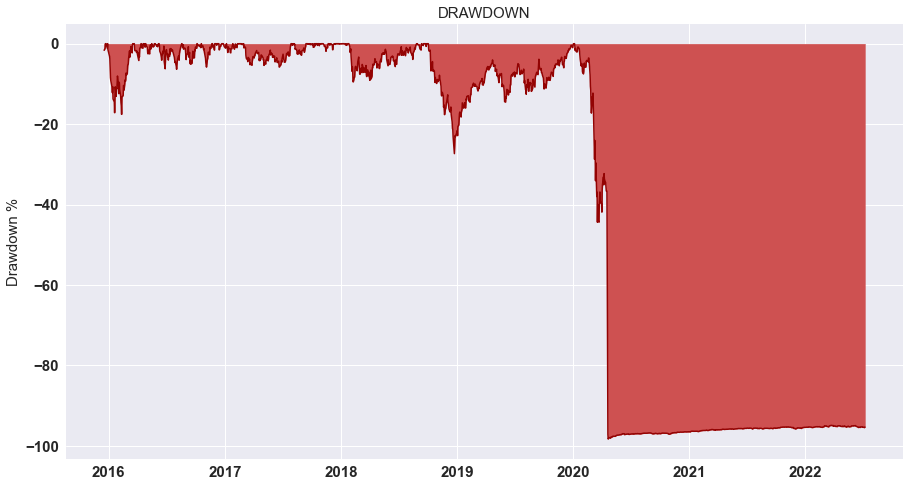

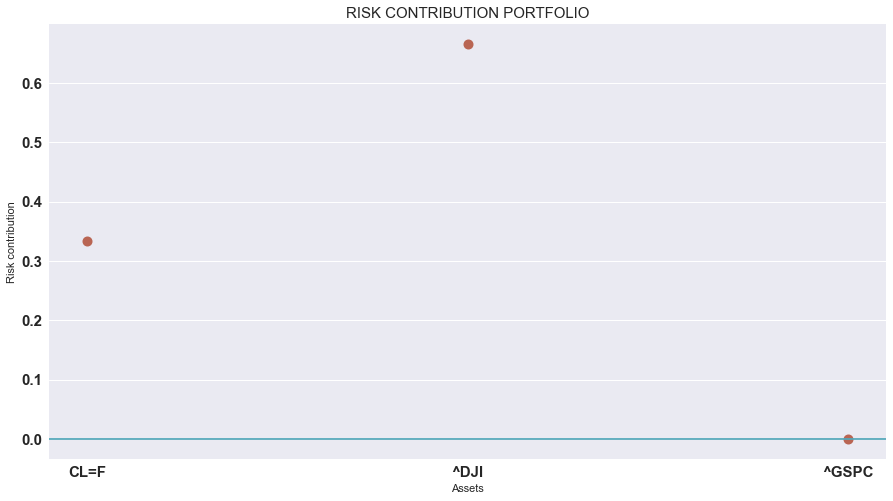

In [37]:
backtest_static_portfolio(X_SOR, test_set, CR=True)